In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
import collections, numpy
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import tree
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_data(path,target):
    df = pd.read_csv(path)
    y = df[target]
    X = df.drop(labels = target, axis = 1)
    X = X.apply(pd.to_numeric)
    return df,X,y

In [3]:
#Get Train Dataset
def get_train(i):
    file = 'Data/NSL-KDD/modified/Train/Normal_Data/N' + str(i) + '.csv'
    train_df, train_X, train_y = load_data(file,'defects')
    y_train = []
    for instance in train_y.values:
        if instance == 'normal':
            y_train.append(1)
        else:
            y_train.append(-1)
    train_df.defects.unique()
    return train_df,train_X,y_train

#Get Test Dataset
def get_test(i):
    file = 'Data/NSL-KDD/modified/Train/5_anomaly/A' + str(i) + '.csv'
    train_df, train_X, train_y = load_data(file,'defects')
    y_train = []
    for instance in train_y.values:
        if instance == 'normal':
            y_train.append(1)
        else:
            y_train.append(-1)
    train_df.defects.unique()
    return train_df,train_X,y_train

#Divide data

def divide_data(df):
    target = 'defects'
    y = df[target]
    X = df.drop(labels = target, axis = 1)
    X = X.apply(pd.to_numeric)
    y_train = []
    for instance in y.values:
        if instance == 'normal':
            y_train.append(1)
        else:
            y_train.append(-1)
    return X,y_train

In [113]:
def train_model(train_X, train_y):
    clf = tree.DecisionTreeClassifier(criterion = 'entropy')
    clf.fit(train_X, train_y)
    return clf

def test_model(clf, test_X, test_y):
    predicted = clf.predict(test_X)
    precision = metrics.precision_score(test_y,predicted,average='weighted')
    recall = metrics.recall_score(test_y,predicted,average='weighted')
    f1_Score = metrics.f1_score(test_y,predicted,average='weighted')
    x = metrics.classification_report(test_y, predicted,output_dict=True)
    print(metrics.classification_report(test_y, predicted))
    return [precision,recall,f1_Score,x]

def outlier_model(train_X,nu):
    clf =  OneClassSVM(kernel = 'sigmoid',gamma = 'scale',nu=nu,shrinking= False)
    clf.fit(train_X)
    return clf

In [105]:
# One Set
df_combined = pd.DataFrame([])
perf_score = []
first = True
for i in range(10):
    print("Iteration :", i)
    Ai, Ai_X, Ai_y = get_train(i)
    Aj, Aj_X, Aj_y = get_test(i)
    if first:
        df_combined = pd.concat([df_combined,Ai], ignore_index=True)
        first = False
    else:
        df_combined = pd.concat([df_combined,train_df], ignore_index=True)
    #print("training Classes:",df_combined.defects.unique(),df_combined.shape)
    X,y = divide_data(df_combined)
    if i < 6:
        clf = train_model(X,y)
    train_df = Aj
    #print("Testing Classes Normal:",df_combined.defects.unique(),df_combined.shape)
    
    perf_score.append(test_model(clf,Ai_X, Ai_y))
    #print("Testing Classes Anomaly:",df_combined.defects.unique(),df_combined.shape)
    perf_score.append(test_model(clf,Aj_X, Aj_y))

Iteration : 0
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       649
           1       1.00      1.00      1.00      1166

   micro avg       1.00      1.00      1.00      1815
   macro avg       1.00      1.00      1.00      1815
weighted avg       1.00      1.00      1.00      1815

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       583
           1       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00       583
   macro avg       0.00      0.00      0.00       583
weighted avg       0.00      0.00      0.00       583

Iteration : 1
              precision    recall  f1-score   support

          -1       0.96      1.00      0.98       649
           1       1.00      0.98      0.99      1166

   micro avg       0.98      0.98      0.98      1815
   macro avg       0.98      0.99      0.98      1815
weighted avg       0.98      0.98      0.98   

In [114]:
# Another Set outlier
df_combined = pd.DataFrame([])
perf_score = []
first = True
nu = 0.4
for i in range(10):
    print("Iteration :", i)
    Ai, Ai_X, Ai_y = get_train(i)
    Aj, Aj_X, Aj_y = get_test(i)
    if first:
        df_combined = pd.concat([df_combined,Ai], ignore_index=True)
        first = False
    else:
        if n_score[2] < .8:
            print("adding model")
            df_combined = pd.concat([df_combined,Ai], ignore_index=True)
        if a_score[2] < .8:
            df_combined = pd.concat([df_combined,train_df], ignore_index=True)
    #print("training Classes:",df_combined.defects.unique(),df_combined.shape)
    X,y = divide_data(df_combined)
    if i < 6:
        clf = outlier_model(X, nu)
        nu -= 0.05
    train_df = Aj
    #print("Testing Classes Normal:",df_combined.defects.unique(),df_combined.shape)
    n_score = test_model(clf,Ai_X, Ai_y)
    perf_score.append(n_score)
    #print("Testing Classes Anomaly:",df_combined.defects.unique(),df_combined.shape)
    a_score = test_model(clf,Aj_X, Aj_y)
    perf_score.append(a_score)

Iteration : 0
              precision    recall  f1-score   support

          -1       0.63      0.70      0.67       649
           1       0.82      0.77      0.80      1166

   micro avg       0.75      0.75      0.75      1815
   macro avg       0.73      0.74      0.73      1815
weighted avg       0.75      0.75      0.75      1815

              precision    recall  f1-score   support

          -1       1.00      0.48      0.64       583
           1       0.00      0.00      0.00         0

   micro avg       0.48      0.48      0.48       583
   macro avg       0.50      0.24      0.32       583
weighted avg       1.00      0.48      0.64       583

Iteration : 1
adding model
              precision    recall  f1-score   support

          -1       0.66      0.62      0.64       649
           1       0.80      0.82      0.81      1166

   micro avg       0.75      0.75      0.75      1815
   macro avg       0.73      0.72      0.73      1815
weighted avg       0.75      0.75

In [100]:
df_combined = pd.DataFrame([])
perf_score = []
first = True
for i in range(10):
    print("Iteration :", i)
    Ai, Ai_X, Ai_y = get_train(i)
    Aj, Aj_X, Aj_y = get_test(i)
    if first:
        df_combined = pd.concat([df_combined,Ai], ignore_index=True)
        first = False
    else:
        if n_score[2] < .8:
            print("adding model")
            df_combined = pd.concat([df_combined,Ai], ignore_index=True)
        if a_score[2] < .8:
            df_combined = pd.concat([df_combined,train_df], ignore_index=True)
    #print("training Classes:",df_combined.defects.unique(),df_combined.shape)
    X,y = divide_data(df_combined)
    if i < 6:
        clf = train_model(X,y)
    train_df = Aj
    #print("Testing Classes Normal:",df_combined.defects.unique(),df_combined.shape)
    n_score = test_model(clf,Ai_X, Ai_y)
    perf_score.append(n_score)
    #print("Testing Classes Anomaly:",df_combined.defects.unique(),df_combined.shape)
    a_score = test_model(clf,Aj_X, Aj_y)
    perf_score.append(a_score)

Iteration : 0
Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9


In [115]:
perf_score_df = pd.DataFrame(perf_score, columns = ['Precision',
                                                   'Recall',
                                                   'F1-Score','report'])

In [116]:
class_1 = []
class_2 = []
for i in range(perf_score_df.shape[0]):
    class_1.append(perf_score_df.iloc[i,3]['1']['f1-score'])
    class_2.append(perf_score_df.iloc[i,3]['-1']['f1-score'])

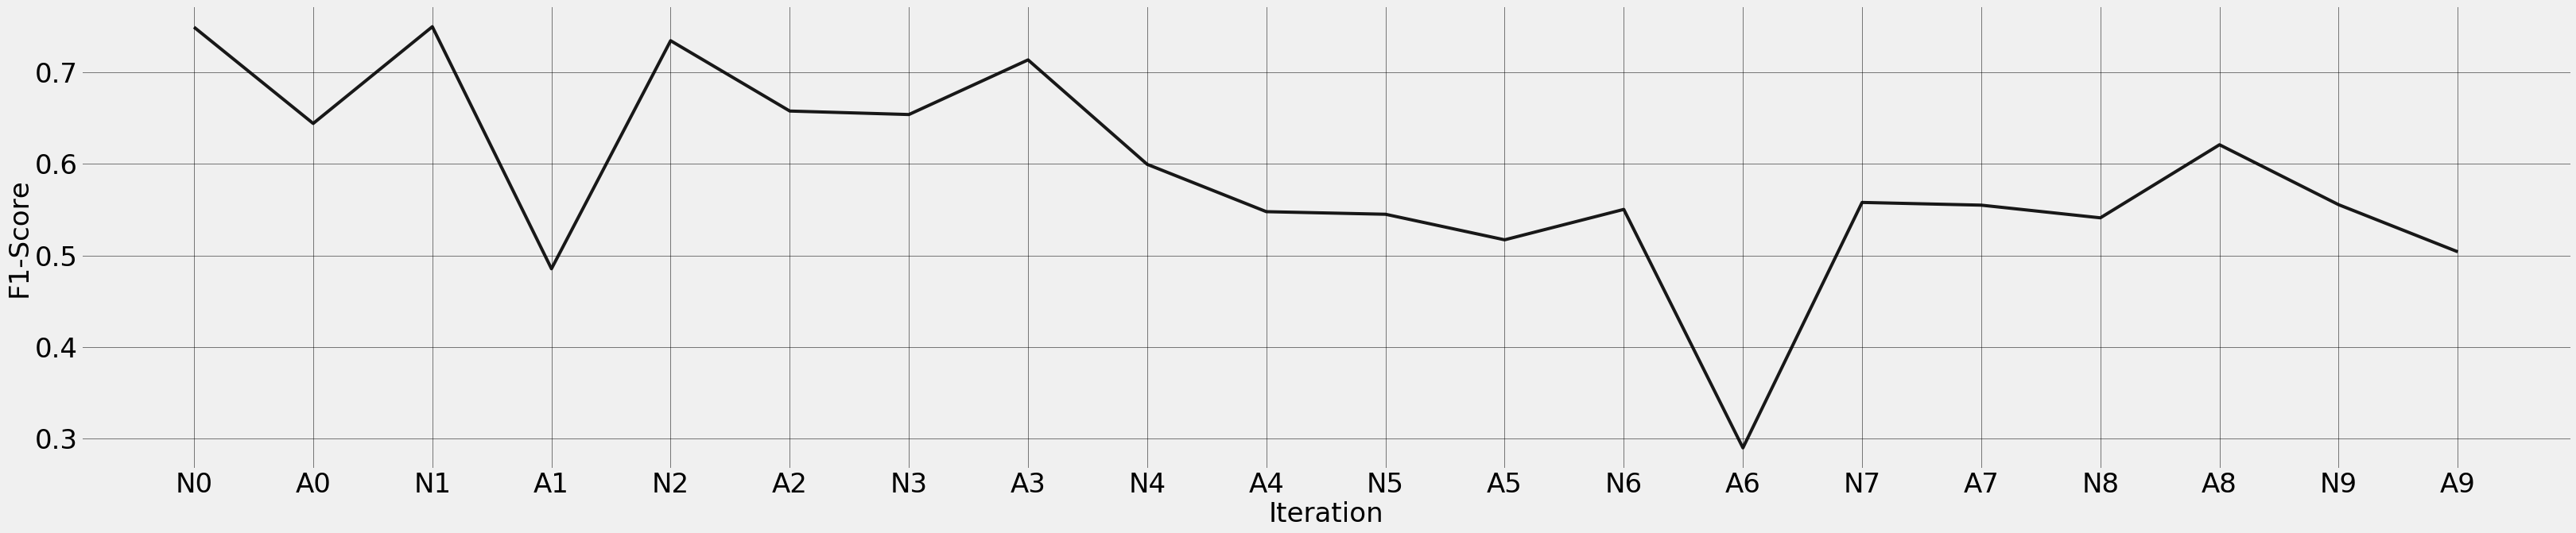

In [118]:
ticks = ['N0','A0','N1','A1','N2','A2','N3','A3','N4','A4','N5','A5','N6','A6','N7','A7','N8','A8','N9','A9']
# style
plt.style.use('fivethirtyeight')
 
# create a color palette
fig = plt.figure(num=None, figsize = (50,10))
score = perf_score_df['F1-Score'].values
ax = fig.add_subplot(1,1,1)
ax.plot(score,marker='', color='black', linewidth=4, alpha=0.9, label='Trained On Classes')
plt.xlabel('Iteration', fontsize=34)
plt.ylabel('F1-Score', fontsize=34)
#ax.set(xlabel='Iteration', ylabel='F1-Score',fontsize = 34)
ax.tick_params(direction='out', labelsize=34,
               grid_color='black', grid_alpha=0.5)
ax.set_xticks(np.arange(20))
ax.set_xticklabels(ticks)
plt.show()

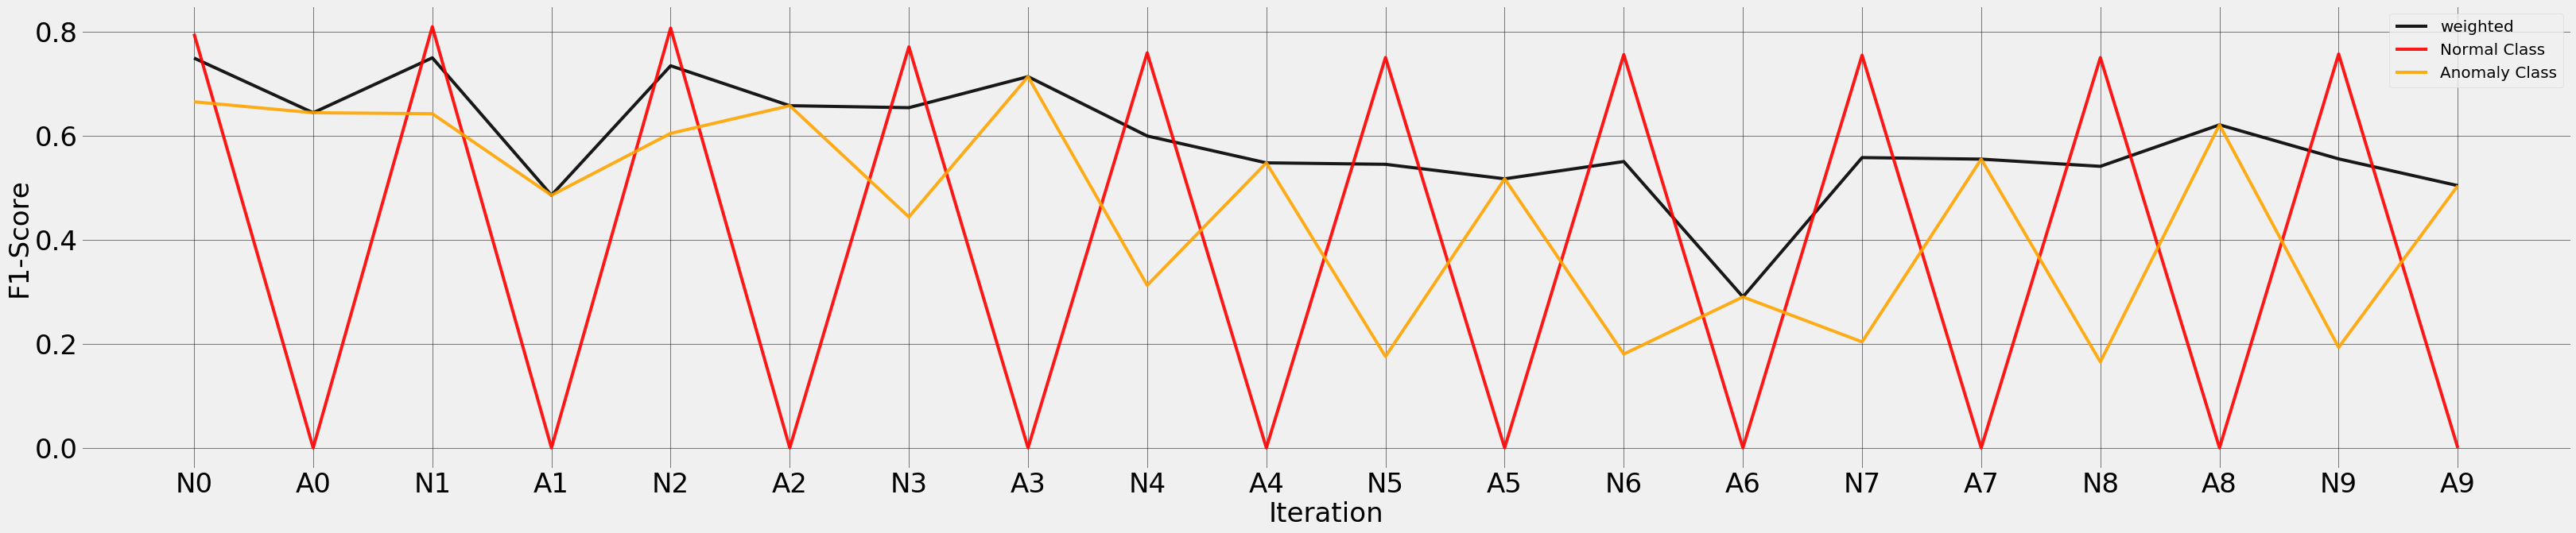

In [117]:
ticks = ['N0','A0','N1','A1','N2','A2','N3','A3','N4','A4','N5','A5','N6','A6','N7','A7','N8','A8','N9','A9']
# style
plt.style.use('fivethirtyeight')
 
# create a color palette
fig = plt.figure(num=None, figsize = (50,10))
score = perf_score_df['F1-Score'].values
ax = fig.add_subplot(1,1,1)
ax.plot(score,marker='', color='black', linewidth=4, alpha=0.9, label='Trained On Classes')
ax.plot(class_1,marker='', color='red', linewidth=4, alpha=0.9, label='Trained On Classes')
ax.plot(class_2,marker='', color='orange', linewidth=4, alpha=0.9, label='Trained On Classes')
ax.legend(['weighted','Normal Class','Anomaly Class'],fontsize=20)
plt.xlabel('Iteration', fontsize=34)
plt.ylabel('F1-Score', fontsize=34)
#ax.set(xlabel='Iteration', ylabel='F1-Score',fontsize = 34)
ax.tick_params(direction='out', labelsize=34,
               grid_color='black', grid_alpha=0.5)
ax.set_xticks(np.arange(20))
ax.set_xticklabels(ticks)
plt.show()